==============================================================================================
# Practicum 5 - Part 2

==============================================================================================

## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented.

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Comments need to be in **english**.

- The deliverable must be a file named **P5_Student1_Student2.zip** that includes:
    - The notebook P5_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.

**Deadline (Group A- Group F): November 30th, 23:00 h**

**Deadline (Group B): November 1st, 23:00 h**

==============================================================================================
##  Image search using textures
==============================================================================================

#### Problem we want to solve
- Given a query image **$x$** and a set of images **$X$** we would like to retreive the most similar to **$x$** images from  **$X$**.

The exercises of this notebook will show how we can perform image similarity search using:

**Part 1:**

- Gaussian filters
- Descriptors based on texture 

**Part 2:**

- Distance between images and similarity search

### Imports

In [1]:
%matplotlib inline

import time
import scipy
import numpy as np
import skimage
from skimage import filters, img_as_ubyte
from skimage.io import imread, imsave
from skimage.color import rgb2gray, rgba2rgb
from skimage.transform import resize

from scipy.ndimage import convolve
import os
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

#import joblib  ## 

Matplotlib is building the font cache; this may take a moment.


# 1 Import previous functions



## Leung-Malik (LM) Filter Bank
We can apply a collection of multiple filters that we call a filter bank. Note that if we apply $D$ filters our feature vectors will be $D$ dimensional.

The following image shows a filter bank. In the filter bank we typically want filters to capture a combination of scales, orientations of different types of patterns. This particular filter bank is The Leung-Malik (LM) Filter Bank.

<img src="./images_notebook/filter_bank.png">

We import Leung-Malik filters as follows:

In [2]:
import LM_filters

LM filters imported, the shape of the filter bank is:  (49, 49, 48)


In [3]:
filter_bank = LM_filters.makeLMfilters()
filter_bank.shape

(49, 49, 48)

### Plotting all filters

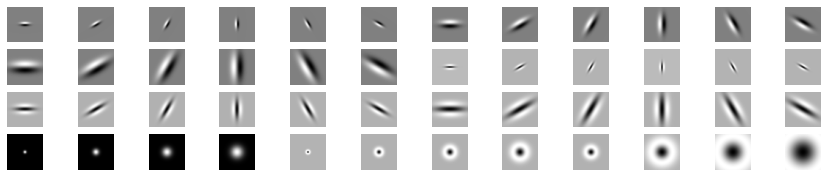

In [4]:
n_filters = filter_bank.shape[-1]

fig, ax = plt.subplots(ncols=12, nrows=4, figsize=(15,3))

k = 0
for i in range(4):
    for j in range(12):
        ax[i,j].imshow(filter_bank[:,:,k], cmap = 'gray')
        ax[i,j].axis("off")
        k = k + 1

## Import functions

We need to use `extract_features()` and  `get_dataset_features()` from **Practicum 5 - Part 1**.

On the one hand, function `extract_features(image, filter_bank, n_filters)` returns a feature vector of shape `n_filters`, from the filter bank, using a  single image `image`

$$
\text{feat}(x) = \left( \text{mean}( |r_1|), \dots,\text{mean}(|r_D|) \right)
$$


In [5]:
def extract_features(image, filter_bank, n_filters):
    features = np.zeros(n_filters)
    ## Complete this function
    for f in range (n_filters):
        filtro = filter_bank[:,:,f]
        result = abs(convolve(image, filtro))
        features[f] = result.mean()
    return features

On the other hand, function `get_dataset_features(all_images, filter_bank)`, that applies `extract_features()`, returns a matrix containing the feature vectors for all the images in a dataset.

In [6]:
def get_dataset_features(all_images,  filter_bank, n_filters=filter_bank.shape[2]):
    n_images = len(all_images)
    feature_vectors=np.zeros((n_images,n_filters))
    i = 0
    ## Complete this function
    print("Extracting features of image:")
    for img in all_images:
        features = extract_features(img, filter_bank, n_filters)
        feature_vectors[i] = features
        print(i, end='...')
        i += 1
    
    return feature_vectors

**Hint: Please, check all the functions are well working before continuing!!!**

## Load & resize the dataset

**3.1** Similarly to **Practicum 5 - Part 1**, read all the images in the directories, **resized them to 250x250 pixels** and save the image in an array:

<ul>
    <li>./images/pizza/</li>
    <li>./images/flowers/</li>
    <li>./images/pets/</li>
</ul>


In [7]:
# Your solution here
def load_resize(path):
    collection = os.listdir(path)
    imgs = []
    for file in collection:
        img = imread(path + file)
        img = rgb2gray(img)
        img = img_as_ubyte(img)
        img = resize(img, (250,250))
        imgs.append(img)
        
    return imgs

In [8]:
# Your solution here
pizza_images = load_resize("./images/pizza/")
flowers_images = load_resize("./images/flowers/")
pets_images = load_resize("./images/pets/")

In [9]:
## Try the function
all_images = pizza_images + flowers_images + pets_images
feature_vectors=get_dataset_features(all_images,  filter_bank, 12) # Reduces computation time

Extracting features of image:
0...1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...


# 2 Retrieving the most similar images


## Similarity search

Let us assume $f(x) \in \mathbb{R}^D$ represents a set of features for $x$. Given a query image $x$ and another image $x^m$ from the database, we can compute the distance between images as
$$
\text{distance}\left( f(x) , \, f(x^m) \right) = \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 =  \sqrt{ \sum_{d=1}^\text{D} \left( f(x)_d - f(x^m)_d  \right)^2 }
$$

then we can find the closest image $x^{m^*}$ from the database to $x$ as $m^* =  \text{argmin}_{m} \{ \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 \}$




**3.2** Implement a function `retrieve_images(im, all_images, filter_bank, k=5)` to retrieve and visualize the `k` most similar images (according to the l2 norm) to `im` and the corresponding distances.

The input of this function need to be the images of interest `im`, the whole data set `all_images`, the filter bank and an integer value `k`, which defines the number of images to be shown.

The function should return the ordered vector of distances.

<img src="./images/indice.png" >


In [10]:
def retrieve_images(im, all_images, feature_vectors, k=5, n_features = 12): # N_features has to be the same to model
    dist_and_img = []
    ## Complete this function
    # Extract features for model image
    gray_image = rgb2gray(im)
    gray_image = img_as_ubyte(gray_image)
    reduced_image = resize(gray_image, (250,250))
    features = extract_features(reduced_image, filter_bank, n_features) # Features setted to model to reduce comp
    
    # Calculate distances between the model and the features for each image
    for i in range(len(all_images)):
        # Apply L2 norm between features
        dist = np.linalg.norm(feature_vectors[i] - features)  
        dist_and_img.append((dist, all_images[i]))
    
    # Sort list by distance
    dist_and_img.sort(key=lambda x:x[0])
    distances = [l[0] for l in dist_and_img][:k]
    closest = [l[1] for l in dist_and_img][:k]
    
    return closest, distances

Try your function using ``/images/pizza.jpg``.

In [11]:
# Try your function
pizza = imread('./images/pizza.jpg')
closest, distances = retrieve_images(pizza, all_images, feature_vectors, k=5)

In [12]:
def show_images(m, n, imgs, labels):
    fig, axes = plt.subplots(m, n, figsize=(13, 6))
    ax = axes.ravel()
    cmap='gray'
    for i in range(m*n):
        ax[i].imshow(imgs[i], cmap)
        ax[i].set_title("Distance: " + "{0:.4f}".format(labels[i]))
        ax[i].axis('off')
        
    plt.tight_layout()
    plt.show()

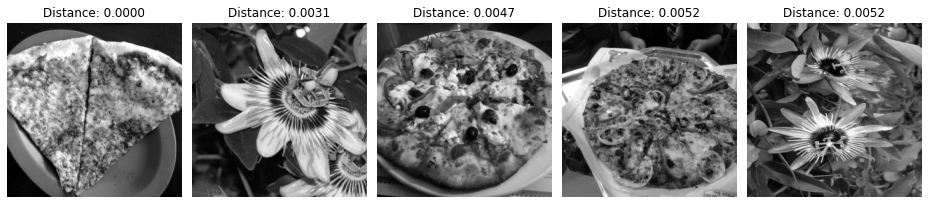

In [13]:
show_images(1, 5, closest, distances)

In [14]:
print(distances)

[0.0, 0.0030502335110233507, 0.004695161929796854, 0.005201130029350015, 0.005240205961168759]


Plot the ordered distance vector

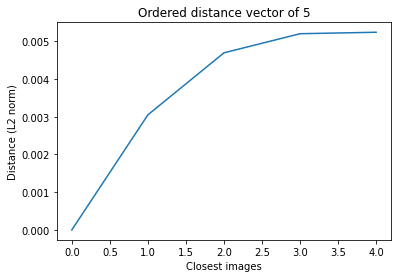

In [15]:
# Your solution here
plt.plot(distances)
plt.title("Ordered distance vector of " + str(len(distances)))
plt.xlabel('Closest images')
plt.ylabel('Distance (L2 norm)')
plt.show()

**3.3** Try your function using a different number of closest images `k`.

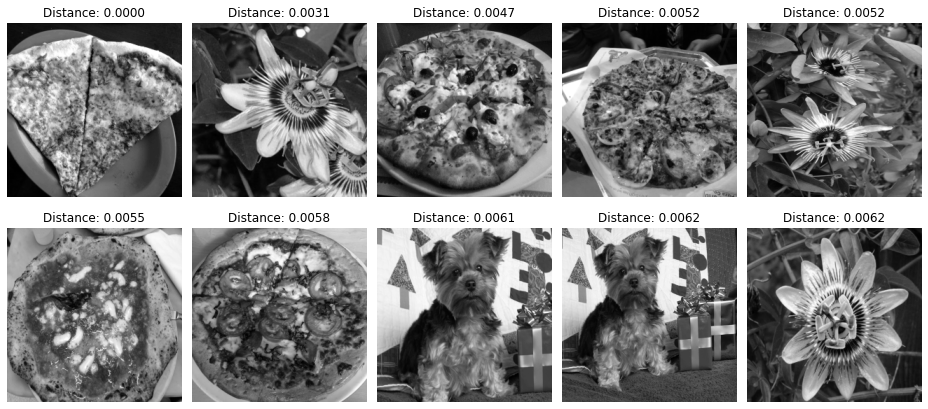

In [16]:
# Your solution here
closest, distances = retrieve_images(pizza, all_images, feature_vectors, k=10)
show_images(2, 5, closest, distances)

**3.4** (Optional) Try your function using ``/images/dog.jpg``, and ``/images/flower.jpg``

In [17]:
# Your solution here

## Compute the accuracy of the algorithm: given a query image. 

**3.5** Implement a function `accuracy(feature_vectors, class_labels, im_features, class_im,  k=5)`, which takes as input `feature_vectors`, the `class_labels` for the images (`0 = pizza`, `1 = flower` and `2 = pet`), the number of images to retrieve `k`, a query image (i.e. the feature vector for the image of interest) and the class of the query image `class_im`. 

Returns as output the number of retrieved images that belong to class `class_im` divided by the total of images retrieved `k` (this is the accuracy).

**Hint**: Be careful to exclude the query image from the retrieved images (i.e. those cases in which `distance=0.0`)

In [18]:
class_labels = np.concatenate((np.zeros(30), np.ones(28),  2*np.ones(29))).reshape(87,1)

In [19]:
def accuracy(feature_vectors, class_labels, im_features, class_im, k=5):
    ## Complete this function
    dist_img_pos = []
    # Calculate distances between the model and the features for each image
    for i in range(len(feature_vectors)):
        # Apply L2 norm between features
        dist = np.linalg.norm(feature_vectors[i] - im_features)  
        dist_img_pos.append((dist, all_images[i], i))
    
    # Sort list by distance
    dist_img_pos.sort(key=lambda x:x[0])
    distances = [l[0] for l in dist_img_pos][:k]
    closest = [l[1] for l in dist_img_pos][:k]
    pos = [l[2] for l in dist_img_pos][:k]
    
    # Remove img with distance equals to 0 (query image), if found
    dist = np.array(distances)
    indice = np.where(dist == 0)
    if  np.size(indice) != 0:
        dist = np.delete(dist, indice)
        k -= 1
        class_labels = np.delete(class_labels, indice)
    
    # Count number of hits
    count = 0
    for p in pos:
        if class_labels[p] == class_im: count +=1 
    return count/(k)

In [20]:
# Read and transform image
im = imread('./images/pizza.jpg')
gray_image = rgb2gray(im)
gray_image = img_as_ubyte(gray_image)
reduced_image = resize(gray_image, (250,250))

# Get the features
im_features = extract_features(reduced_image, filter_bank, 12)
# Try your function
class_im = 0 # pizza
print("acc: {:.2%}".format(accuracy(feature_vectors, class_labels, im_features, class_im, k=5)))

acc: 50.00%


Compute the accuracy with k=10 with the previous images. Does the accuracy match the images retrieved from the previous exercise?

In [21]:
# Get the features
im_features = extract_features(reduced_image, filter_bank, 12)
# Try your function
class_im = 0 # pizza
print("acc: {:.2%}".format(accuracy(feature_vectors, class_labels, im_features, class_im, k=10)))

acc: 44.44%


**R**: Yes, as we can see, the accuracy matches with the previous exercise.

**3.6** Modify (if necessary) functions `extract_features()` and `get_dataset_features()` in order to use only a given number of filters. Compute the accuracy using `n_filters=6`, `n_filters=18` and `n_filters=36`. 

Comment the results.

In [22]:
# Your solution here
# For n_filters=6
im_features = extract_features(reduced_image, filter_bank, 6)
feature_vectors = get_dataset_features(all_images,  filter_bank, 6)
class_im = 0 # pizza
print("\nacc: {:.2%}".format(accuracy(feature_vectors, class_labels, im_features, class_im, k=5)))

Extracting features of image:
0...1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...
acc: 50.00%


In [23]:
# For n_filters=18
im_features = extract_features(reduced_image, filter_bank, 18)
feature_vectors = get_dataset_features(all_images,  filter_bank, 18)
class_im = 0 # pizza
print("\nacc: {:.2%}".format(accuracy(feature_vectors, class_labels, im_features, class_im, k=5)))

Extracting features of image:
0...1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...
acc: 50.00%


In [24]:
# For n_filters=36
im_features = extract_features(reduced_image, filter_bank, 36)
feature_vectors = get_dataset_features(all_images,  filter_bank, 36)
class_im = 0 # pizza
print("\nacc: {:.2%}".format(accuracy(feature_vectors, class_labels, im_features, class_im, k=5)))

Extracting features of image:
0...1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...
acc: 50.00%


**R**: Is expected that with more filters, the accuracy will be better. But for the closest 5 images (except the model), the accuracy doesn't have improved.

**3.7** (Optional) Try your function using other images and modifying the number of filters to be used.

**Hint:** You can use `im_features = feature_vectors[j]` and `class_im = class_labels[j]`, for a given `j` value, in order to simplify the problem, instead of recomputing the features for a new image. **Remember** to exclude the query image from the retrieved images!.

In [25]:
# Your solution here

# 3 Image retrieval based on texture and color. 

**3.8** Make a function ` lm_features_rgb`  that returns the features based on a color descriptor. 

**Hint:** How will you define it? What should be the dimensonality of the new descriptor?.


In [26]:
def load_resize_rgb(path):
    collection = os.listdir(path)
    imgs = []
    for file in collection:
        img = imread(path + file)
        img = img_as_ubyte(img)
        img = resize(img, (250,250))
        imgs.append(img)
        
    return imgs

In [27]:
def lm_features_rgb(image, filter_bank, n=filter_bank.shape[-1]):
    # We define the matrix
    features_for_im = np.zeros(3*n)
    
    # Extract the features of every channel of the image
    r = extract_features(image[:,:,0], filter_bank, n)
    g = extract_features(image[:,:,1], filter_bank, n)
    b = extract_features(image[:,:,2], filter_bank, n)
    
    # And concatenate them
    features_for_im = np.concatenate((r, g, b))
        
    return features_for_im

In [28]:
# Try your function
# Read original images
pizza_images = load_resize_rgb("./images/pizza/")
flowers_images = load_resize_rgb("./images/flowers/")
pets_images = load_resize_rgb("./images/pets/")
all_images = pizza_images + flowers_images + pets_images

# Apply lm_features
lm_rgb_features = lm_features_rgb(all_images[0], filter_bank, n=6) # 6 filters only
print(lm_rgb_features.shape)

(18,)


**R**: The new descriptor should have a length of 18.


## Apply the function to all the images in the dataset

**3.9** Using ` lm_features_rgb` build the features of all the datapoints in and save them in `X_lm_rgb`.

**Hint:** You can parallelize the feature building process using `joblib.Parallel`. This will make the computation much faster if you have a processor with more than two threads.

In [29]:
def features_all_images(all_images, filter_bank, n_f=filter_bank.shape[-1]):
    n_i = len(all_images)
    imgs = np.zeros((n_i,n_f*3))
    
    # For every image we extract the features based on a color descriptor
    print("Extracting features of image:")
    for i in range(0,n_i):
        imgs[i] = lm_features_rgb(all_images[i], filter_bank, n_f)
        print(i, end='...')

    # Finally, we return the result
    return imgs

X_lm_rgb = features_all_images(all_images, filter_bank, n_f=6) # 6 filters only
np.save('xlmrgb.npy',X_lm_rgb)

Extracting features of image:
0...1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...

In [30]:
X_lm_rgb = joblib.Parallel(n_jobs=8)(joblib.delayed(lm_features_rgb)(im) for im in all_images)

NameError: name 'joblib' is not defined

## Compute the accuracy of the method using lm rgb features

**3.10** Compute the accuracy of the retrieved images using the features that contain color information. Make a plot of the 4 closest images to the query images in the `lm_rgb` space.

Is the accuracy higher? Please, comment the results.

In [31]:
def accuracy_rgb(X_lm_rgb, class_labels, im_features, class_im, k=5):
    ## Complete this function
    dist_img_pos = []
    # Calculate distances between the model and the features for each image
    for i in range(len(X_lm_rgb)):
        # Apply L2 norm between features
        dist = np.linalg.norm(X_lm_rgb[i] - im_features)  
        dist_img_pos.append((dist, all_images[i], i))
    
    # Sort list by distance
    dist_img_pos.sort(key=lambda x:x[0])
    distances = [l[0] for l in dist_img_pos][:k]
    closest = [l[1] for l in dist_img_pos][:k]
    pos = [l[2] for l in dist_img_pos][:k]
    
    # Remove img with distance equals to 0 (query image), if found
    dist = np.array(distances)
    indice = np.where(dist == 0)
    if  np.size(indice) != 0:
        dist = np.delete(dist, indice)
        k -= 1
        class_labels = np.delete(class_labels, indice)
    
    # Count number of hits
    count = 0
    for p in pos:
        if class_labels[p] == class_im: count +=1 
    return count/(k)   

In [32]:
# Test RGB accuracy
im = imread('./images/pizza.jpg')
reduced_image = resize(im, (250,250))

im_features = lm_features_rgb(reduced_image, filter_bank, 6)
class_im = 0 # pizza
print("acc RGB: {:.2%}".format(accuracy_rgb(X_lm_rgb, class_labels, im_features, class_im, k=5)))

acc RGB: 75.00%


**R**: Yes, the accuracy is higher than the obtained on the previous exercise (gray image).

## Compare the accuracy of the method using a) texture, b) color and c) texture + color  features

**3.10** Compute the accuracy of the retrieved images using the features that contain color information. Make a plot of the 4 closest images to the query images in the `lm_rgb` space.

Is the accuracy higher? Please, comment the results.

In [33]:
def retrieve_images_rgb(im, all_images, feature_vectors, k=5, n_features = 6): # N_features has to be the same to model
    dist_and_img = []
    # Extract features for model image
    reduced_image = resize(im, (250,250))
    features = lm_features_rgb(reduced_image, filter_bank, n_features) # Features setted to model to reduce comp
    
    # Calculate distances between the model and the features for each image
    for i in range(len(all_images)):
        # Apply L2 norm between features
        dist = np.linalg.norm(feature_vectors[i] - features)  
        dist_and_img.append((dist, all_images[i]))
    
    # Sort list by distance
    dist_and_img.sort(key=lambda x:x[0])
    distances = [l[0] for l in dist_and_img][:k]
    closest = [l[1] for l in dist_and_img][:k]
    
    return closest, distances

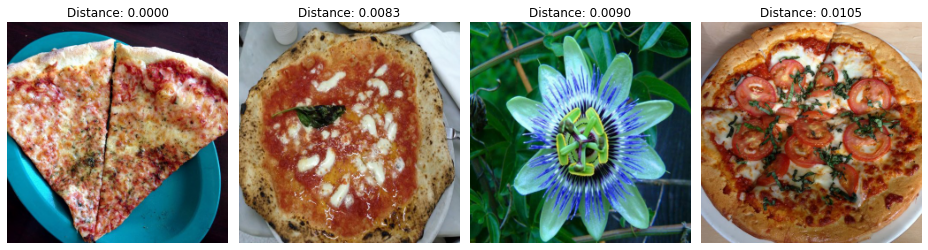

In [34]:
# Show 4 closest images (including the model)
pizza = imread('./images/pizza.jpg')
closest, distances = retrieve_images_rgb(pizza, all_images, X_lm_rgb, k=5)
show_images(1, 4, closest, distances)

**R**: Yes, the accuracy is higher than the obtained on the previous exercise (gray image).


**3.11** Compute the accuracy of the retrieved images using the features that contain texture and color information. Make a plot of the 4 closest images to the query images in the `lm_rgb_texture` space.

Is the accuracy higher? Please, comment the results.

In [35]:
def lm_rgb_texture(im, all_images, feature_vectors, k=5, n_features = 6): # N_features has to be the same to model
    dist_and_img = []
    # Extract features for model image
    gray_image = rgb2gray(im)
    gray_image = img_as_ubyte(gray_image)
    reduced_image_gray = resize(gray_image, (250,250))
    reduced_image_rgb = resize(im, (250,250))
    
    features = extract_features(reduced_image_gray, filter_bank, n_features)
    features = np.concatenate((features, lm_features_rgb(reduced_image_rgb, filter_bank, n_features)))
    
    # Calculate distances between the model and the features for each image
    for i in range(len(all_images)):
        # Apply L2 norm between features
        dist = np.linalg.norm(feature_vectors[i] - features)  
        dist_and_img.append((dist, all_images[i]))
    
    # Sort list by distance
    dist_and_img.sort(key=lambda x:x[0])
    distances = [l[0] for l in dist_and_img][:k]
    closest = [l[1] for l in dist_and_img][:k]
    
    return closest, distances

In [36]:
# Retrieve feature vectors of gray images
pizza_images = load_resize("./images/pizza/")
flowers_images = load_resize("./images/flowers/")
pets_images = load_resize("./images/pets/")
## Try the function
all_images = pizza_images + flowers_images + pets_images
feature_vectors=get_dataset_features(all_images,  filter_bank, 6) # Reduces computation time

Extracting features of image:
0...1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...

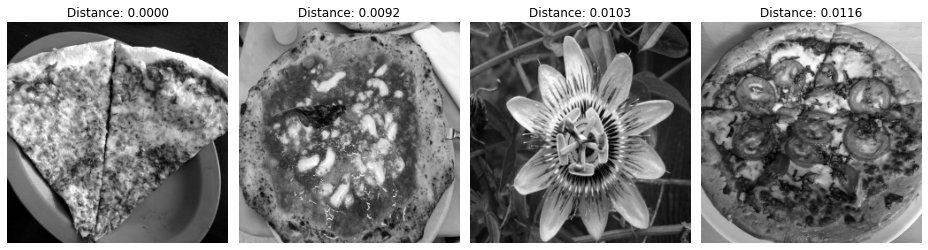

In [37]:
# Show 4 closest images (including the model)
pizza = imread('./images/pizza.jpg')
closest, distances = lm_rgb_texture(pizza, all_images, np.concatenate((feature_vectors, X_lm_rgb), axis=1), k=5)                               
show_images(1, 4, closest, distances)

In [38]:
def accuracy_rgb_texture(feature_vectors, class_labels, im_features, class_im, k=5):
    ## Complete this function
    dist_img_pos = []
    # Calculate distances between the model and the features for each image
    for i in range(len(feature_vectors)):
        # Apply L2 norm between features
        dist = np.linalg.norm(feature_vectors[i] - im_features)  
        dist_img_pos.append((dist, all_images[i], i))
    
    # Sort list by distance
    dist_img_pos.sort(key=lambda x:x[0])
    distances = [l[0] for l in dist_img_pos][:k]
    closest = [l[1] for l in dist_img_pos][:k]
    pos = [l[2] for l in dist_img_pos][:k]
    
    # Remove img with distance equals to 0 (query image), if found
    dist = np.array(distances)
    indice = np.where(dist == 0)
    if  np.size(indice) != 0:
        dist = np.delete(dist, indice)
        k -= 1
        class_labels = np.delete(class_labels, indice)
    
    # Count number of hits
    count = 0
    for p in pos:
        if class_labels[p] == class_im: count +=1 
    return count/(k)   

In [39]:
# Get accuracy based on texture + RGB features
im = imread('./images/pizza.jpg')
gray_image = rgb2gray(im)
gray_image = img_as_ubyte(gray_image)
reduced_image_gray = resize(gray_image, (250,250))
reduced_image_rgb = resize(im, (250,250))

features = extract_features(reduced_image_gray, filter_bank, 6)
features = np.concatenate((features, lm_features_rgb(reduced_image_rgb, filter_bank, 6)))
class_im = 0 # pizza
print("acc texture + RGB: {:.2%}".format(accuracy_rgb_texture(np.concatenate((feature_vectors, X_lm_rgb), axis=1),
                                                              class_labels, features, class_im, k=5)))

acc texture + RGB: 75.00%


**R**: The accuracy is equal to the accuracy found at the previous exercise (RGB features). But this could happen because we are using only 6 of 48 filters and taking to account only the five closest images. As we increase the number of filters or/and closest images, the accuracy should be higher.